In [110]:
import matplotlib.pyplot as plt
import numpy as np
import openpyxl

### Scrape spectral data

In [111]:
dframe = openpyxl.load_workbook("../data/Mineral spectra with ASD.xlsx")

In [112]:
endMemMap = {}

for tendMem in dframe.sheetnames :    
    endMem = tendMem.lower()
    
    if tendMem not in endMemMap :
        endMemMap[endMem] = {}
        endMemMap[endMem]["ASD wavelength"]  = []
        endMemMap[endMem]["ASD reflectance"] = []
    
    for row in dframe[tendMem].iter_rows(2,dframe[tendMem].max_row):
        endMemMap[endMem]["ASD wavelength"]  += [row[0].value]
        endMemMap[endMem]["ASD reflectance"] += [row[1].value]

In [113]:
dframe = openpyxl.load_workbook("../data/Mineral spectra with BECK.xlsx")

In [114]:
for tendMem in dframe.sheetnames :
    endMem = tendMem.lower()

    if tendMem not in endMemMap :
        endMemMap[endMem] = {}
        endMemMap[endMem]["BECK wavelength"]  = []
        endMemMap[endMem]["BECK reflectance"] = []
        
    if "ASD wavelength" in endMemMap[endMem] :
        print("\t - ",tendMem," has both BECK and ASD spectra.")
        
    for row in dframe[tendMem].iter_rows(2,dframe[tendMem].max_row):
        endMemMap[endMem]["BECK wavelength"]  += [row[0].value]
        endMemMap[endMem]["BECK reflectance"] += [row[1].value]

In [115]:
dframe    = openpyxl.load_workbook("../data/Mineral spectra with stated peaks.xlsx")
asdNames  = "Calcite,Gibbsite,Goethite,Kaolinite,Montmorillonite".split(',')
beckNames = "Ammonio-Smectite,Hematite,Illite".split(',')

In [116]:
for tendMem in dframe.sheetnames :
    endMem = tendMem.lower()
    
    ttype = "ASD"
    if tendMem in beckNames :
        ttype = "BECK"
            
    if tendMem not in endMemMap :
        endMemMap[endMem] = {}
        endMemMap[endMem][ttype+" wavelength"]  = []
        endMemMap[endMem][ttype+" reflectance"] = []
    
    if "ASD wavelength" in endMemMap[endMem] and "BECK wavelength" in endMemMap[endMem] :
        print("\t - ",tendMem," has both BECK and ASD spectra.")
        
    for row in dframe[tendMem].iter_rows(2,dframe[tendMem].max_row):
        endMemMap[endMem][ttype+" wavelength"]  += [row[0].value]
        endMemMap[endMem][ttype+" reflectance"] += [row[1].value]

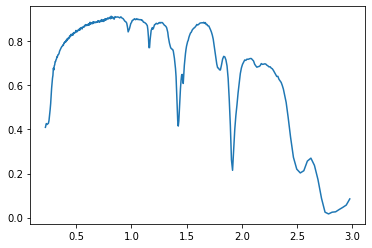

In [117]:
plt.plot(endMemMap["analcime"]["BECK wavelength"],endMemMap["analcime"]["BECK reflectance"])

### Scrape size, density, and other data

In [124]:
dframe = openpyxl.load_workbook("../data/Soil endmember mastersheet.xlsx")

Get chemical formula data, absorption peaks, and USGS reference information:

In [125]:
for row in dframe["USGS_spectra"].iter_rows(2,dframe["USGS_spectra"].max_row):
    if row[2].value is None : continue
    tendMem = row[2].value
    endMem = tendMem.lower()
    
    if endMem not in endMemMap :
        print("\t - Key not in endmember map:",endMem)
        continue
        
    endMemMap[endMem]["Chemical formula"] = row[3].value
    endMemMap[endMem]["Absorption peaks (nm)"] = row[4].value
    endMemMap[endMem]["USGS Library Spectrum Title"] = row[6].value
    endMemMap[endMem]["USGS Notes"] = row[8].value

	 - Key not in endmember map: pyrolusite
	 - Key not in endmember map: chlorites
	 - Key not in endmember map: hydroxyapatite
	 - Key not in endmember map: chloroapatite
	 - Key not in endmember map: fluoroapatite
	 - Key not in endmember map: halloysite


Get mineral information:

In [126]:
for row in dframe["Minerals"].iter_rows(2,dframe["Minerals"].max_row):
    if row[1].value is None : continue
    tendMem = row[1].value
    endMem = tendMem.lower()
    
    if row[7].value != "TRUE" : continue
    
    if endMem not in endMemMap :
        print("\t - Mineral has USGS spectrum but is not in endmember map:",endMem)
        endMemMap[endMem] = {}
        
    if "Chemical formula" not in endMemMap[endMem] :
        endMemMap[endMem]["Chemical formula"] = row[2].value
    endMemMap[endMem]["Mineral class"] = row[3].value
    if row[4].value is not None :
        endMemMap[endMem]["Silicate class"] = row[4].value
    if row[5].value is not None :
        endMemMap[endMem]["Silicate mineral subclass"] = row[5].value
    endMemMap[endMem]["Mineral absorption peaks (nm)"] = row[8].value
    endMemMap[endMem]["Mineral absorption widths (nm)"] = row[9].value
    endMemMap[endMem]["Minerals Notes"] = row[15].value

Get mass densities and radii:

In [127]:
for row in dframe["density_radius"].iter_rows(2,dframe["density_radius"].max_row):
    if row[2].value is None : continue
    tendMem = row[2].value
    endMem = tendMem.lower()
        
    # for now, skip if not in the USGS spectrum list
    if endMem not in endMemMap : 
        #print("\t - Skipping mineral:",endMem)
        continue
    
    trho = row[7].value
    trad = row[8].value
    
    if trho is None :
        print("\t - Mineral has no density data:",endMem)
        
    if trad is None :
        print("\t - Mineral has no radius data:",endMem)
    
    # calculate actual density from table entry
    if isinstance(trho,float) : 
        rho = trho 
    elif trho is None : 
        rho = 2.0
    else : np.mean(np.array([float(x) for x in trho.split('-')]))
    
    # calculate actual radius from table entry
    if isinstance(trad,float) : 
        rad = trad
    elif trad is None :
        rad = 0.500
    else :
        rad = trad.split(',')[0]
        rad = rad.split('*')
        rad = [np.mean(np.array([float(x) for x in y.split('-')])) for y in rad]
        rad = np.prod(np.array(rad))
        rad = (rad * 3./4. / np.pi) ** (1./3.)
    
    # save data
    endMemMap[endMem]["Density (Mg/m^3)"] = rho
    endMemMap[endMem]["Effective Radius (nm)"] = rad    

	 - Mineral has no radius data: gibbsite
	 - Mineral has no radius data: diaspore
	 - Mineral has no radius data: corundum
	 - Mineral has no radius data: forsterite
	 - Mineral has no radius data: topaz
	 - Mineral has no radius data: andalusite
	 - Mineral has no radius data: staurolite
	 - Mineral has no radius data: epidote
	 - Mineral has no radius data: beryl
	 - Mineral has no radius data: tourmaline
	 - Mineral has no radius data: augite
	 - Mineral has no radius data: enstatite
	 - Mineral has no radius data: hypersthene
	 - Mineral has no radius data: diopside
	 - Mineral has no radius data: hedenbergite
	 - Mineral has no radius data: wollastonite
	 - Mineral has no radius data: rhodonite
	 - Mineral has no radius data: hornblende
	 - Mineral has no radius data: tremolite
	 - Mineral has no radius data: actinolite
	 - Mineral has no radius data: cummingtonite
	 - Mineral has no radius data: muscovite
	 - Mineral has no radius data: biotite
	 - Mineral has no radius data: phl

In [130]:
#[x if "Density (Mg/m^3)" not in endMemMap[x] else endMemMap[x]["Density (Mg/m^3)"] for x in endMemMap.keys()]

Changes made to soil endmember mastersheet:

- density_radius: "chlorites -> chlorite"
- density_radius: "hematite/haematite -> hematite"
- density_radius: "smectite -> ammonio-smectite"
- density_radius: "hydroxyapatite -> hydroxyl-apatite"
- density_radius: "chloroapatite -> chlorapatite"

In ASD spectra: 

- Duplicate "Magnesite+Hydromag" and turn into two sheets, "Magnesite" and "Hydromagnesite"

In [133]:
import json
with open('endmember spectral data.json', 'w', encoding='utf-8') as f:
    json.dump(endMemMap, f, ensure_ascii=False, indent=4)